In [3]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import pandas as pd


In [102]:
df = pd.read_csv("prod_data_images_v2.csv")

In [103]:
df2 = pd.read_csv("prod_data_images_v2.csv")

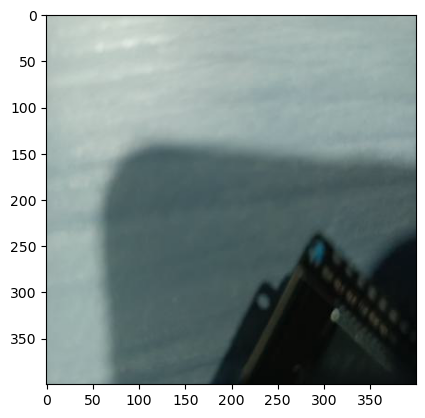

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgPath = "prodFinal/0a0b5290-0ced-4c04-b3fc-c7eecb101967.jpg"
im = cv2.imread(imgPath)
plt.imshow(im)
plt.show()
images = [im]

In [44]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(150, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


(400, 400, 3)


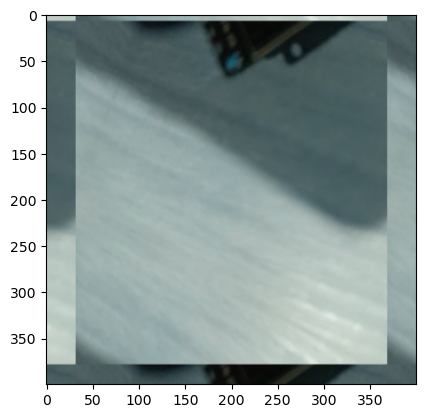

In [89]:
images_aug = seq(images=images)
print(images_aug[0].shape)
plt.imshow(images_aug[0])

In [95]:
imagesdf = df[ df['category_id'] == 2]
imagesdf

,UUID,type,type_id,category,category_id
1120,6d279276-56b3-419b-a7f3-af8b4e3cbb1c,RELE ESTADO SOLIDO,3,rele,2
1121,f6ff905d-e3ff-45d4-bd5a-60688648c7f2,RELE ESTADO SOLIDO,3,rele,2
1122,fc7129f8-995c-4b84-9475-85f9c995a32e,RELE ESTADO SOLIDO,3,rele,2
1123,bb157edf-ef3c-4c28-9991-317f9d3e87de,RELE ESTADO SOLIDO,3,rele,2
1124,cc3eed8b-a01b-41f6-8eb0-b4348a40dc17,RELE ESTADO SOLIDO,3,rele,2
...,...,...,...,...,...
8594,91efc4b9-e5f2-4346-b446-e888ccaba414,rele_3,28,rele,2
8595,09abdb19-80f0-4168-9011-4a37162d62ba,rele_3,28,rele,2
8596,dcecc9b3-b80c-4cbf-b7a9-03522072237e,rele_3,28,rele,2
8597,ef805590-f9b0-4d93-b791-8e7d8ab527c9,rele_3,28,rele,2


In [100]:
int(700/5100)

0

In [104]:
import uuid
objective = 5100


for cate in range(8):
 
    imagesdf = df[ df['category_id'] == cate]
    print("Category ", cate, " images in DF ", imagesdf.shape[0])
    rows = imagesdf.shape[0]
    if rows < 5000:
        imagesPer = int(objective /rows  )
        print("IMAGENES POR ENTIDAD", imagesPer)           
        for index, row in imagesdf.iterrows():
            print(index)
            imageRoute = f"./prodFinal/{row['UUID']}.jpg"
            
            typeStr = row['type']
            typeID = row['type_id']
            categorySTR = row['category']
            categoryID = row['category_id']
            imageRead = cv2.imread(imageRoute)
            image_rgb = cv2.cvtColor(imageRead, cv2.COLOR_BGR2RGB)
            for x in range(imagesPer):
                strUuid = str(uuid.uuid4())
                images_aug = seq(images=[image_rgb])
                newImage = images_aug[0]
                cv2.imwrite(f"./augmentedData/{strUuid}.jpg", newImage)
                new_row = {'UUID': strUuid, 
                           'type': typeStr,
                           'type_id': typeID,
                           'category': categorySTR,
                           'category_id': categoryID }
                df2.loc[len(df2)] = new_row
                

            
            
            


Category  0  images in DF  7152
Category  1  images in DF  791
IMAGENES POR ENTIDAD 6
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
75

In [105]:
df2

,UUID,type,type_id,category,category_id
0,5289153b-8f84-4009-ab58-444e80d1488d,ESP32,0,microcontrolador,0
1,755d4437-63e7-4da0-87cf-ea21770ba7b8,ESP32,0,microcontrolador,0
2,95591867-3fe3-4b09-9cf9-405e48cd7a65,ESP32,0,microcontrolador,0
3,cbf7f8e2-be62-46a8-9991-3bc668f987dd,ESP32,0,microcontrolador,0
4,3fb43bc9-2ca8-4039-a979-d5406e007eb1,ESP32,0,microcontrolador,0
...,...,...,...,...,...
46675,65356008-d76f-4988-8d98-dc2cee442d96,trans_530,61,transistor,7
46676,2d95ca8c-4579-46c5-a712-ae15bccb9be1,trans_530,61,transistor,7
46677,f614e4c5-076a-48ba-a3ac-2f29e68e2429,trans_530,61,transistor,7
46678,1083c118-35c0-4b0e-8e44-a029a59e5efd,trans_530,61,transistor,7


In [106]:
df2.to_csv("prod_data_images_v3.csv", encoding='utf-8', index=False)